# Mushroom  Species Classification 

The purpose of this project is for me to learn about deep learning with PyTorch, using the fastai front end. 

**Keywords:** neural nets, deep learning, pytorch, fastai, transfer learning, fine tuning, one cycle learning, boot strapping, fine grain classification. 

## Introduction

Being able to tell one mushroom species from another can mean the difference between picking yourself a tasty meal or ending up with something that could make you sick or even lead to death. Approximately 14,000 species of mushrooms have been cataloged worldwide and creating a classifier that has been trained on all of these species presents a data collection challenge that I was not prepared to undertake. In this project, I wanted to perform the data collection and data cleaning steps myself, to keep things manageable I decided to work toward creating a classifier that will be useful to people foraging in a more localized geographical area. I learned that mushroom foraging is a popular activity in the Canadian province of British Columbia. Being a Canadian myself, this is the region I decided to focus my efforts on. 

## Data exploration and cleaning

The list of species of mushroom to included in this project was obtained from [The University of British Columbia Zoology website](https://www.zoology.ubc.ca/~biodiv/mushroom/). This directory contains a list of edible and poisonous species of coastal BC and the Pacific Northwest. There are three reasons that I choose this database to draw from:

    1. This list includes the majority of the most common mushroom species found in BC.
  
As a result, even though my classifier only includes 73 species of mushrooms (of the thousands of possible species), my final mushroom classifier may have some utility for people searching for mushrooms in this limited geographical region. 
   
    2. The list contains numerous instances of mushroom species coming from the same family.
    3. Included in the information provided about each species is a list of mushroom species that look similar to the given species. 
    
This is desirable because it adds a significant challenge to the problem. It would have been much easier to distinguish between species of mushrooms that have substantially different features. Using the information about similarity, 18 species of mushroom that looked similar to the 58 species of mushrooms in the UBC database where identified, giving a total of 76 species.  

The top 300 images (using the species name as the search term) were downloaded from bing image search using [Google/Bing Images Web Downloader](https://github.com/ultralytics/google-images-download).

This tool had the advantage of allowing me to automate the gathering of a data set containing over 22,000 images in 76 categories. However, this automation comes at the cost of introducing a substantial amount of noise into the data set. The top 300 image search results included the following types of undesired images:

    1. Cartoon images
    2. Images that did not contain mushrooms
    3. Images that contained more than one type of mushroom
    4. Images that were too zoomed out
    5. Images that were too close up
    6. Images with writing or objects obscuring the mushrooms
    7. Images that featured objects such as people, swiss army knives, baskets, tupperware, cell phones
    8. Images that did not contain any intact mushrooms
    9. Black and white images
    10. duplicate images
    11. Images of cooked mushrooms
    12. Images of moldy mushrooms
    13. Blurry images 
    14. Images that were too small
    15. Low contrast images

My reasoning for removing these images was that they would be misleading the classifier in some way. For instance, I noticed that several images contained a swiss army knife. These images originated from the same source, it appeared that this person had taken pictures of various mushrooms with the swiss army knife included for size comparison. If those images were included in the training set, they could easily be confused for one another and lead to misclassification of the mushroom in the image. The initial data set was cleaned by me, I made two passes through the entire set of images, looking at each image, and deleting any misleading images. In the process of doing this, three of the categories ended up with fewer than 50 images, these categories were excluded from the final data set. The final data set contains 16729 images from 73 categories, 80 percent of the images were used for training, the remaining 20 percent was used for validation (sometimes also referred to as the test set). Looking through every single image like this is very time consuming and tedious (in this case I spent nearly 15 hours), at the same time, data cleaning is an indispensable part of any machine learning workflow. 

> The first step to training a neural net is to not touch any neural net code at all and instead begin by thoroughly inspecting your data. This step is critical. I like to spend a copious amount of time (measured in units of hours) scanning through thousands of examples, understanding their distribution, and looking for patterns.
-- Andrej Karpathy (Director of AI, Tesla)

Some of these types of noise such as images of non-mushroom and cartoon images can be removed from the data set without introducing substantial limitations as to the types of images that can be input by a user in the final production model. Removal of other types of noise (zoomed out images, zoomed-in images, blurry images, etc...) introduces limitations on the generalizability of the model that need to be communicated to the user so that she can obtain the most reliable predictions from the model. For example, the limitations on the input image might read: Pictures should be in colour, from close up, of the whole intact fresh (not rotted, not cooked) mushroom(s). It may also be a good idea to further guide the user by providing examples of acceptable and unacceptable images.

Acceptable images:

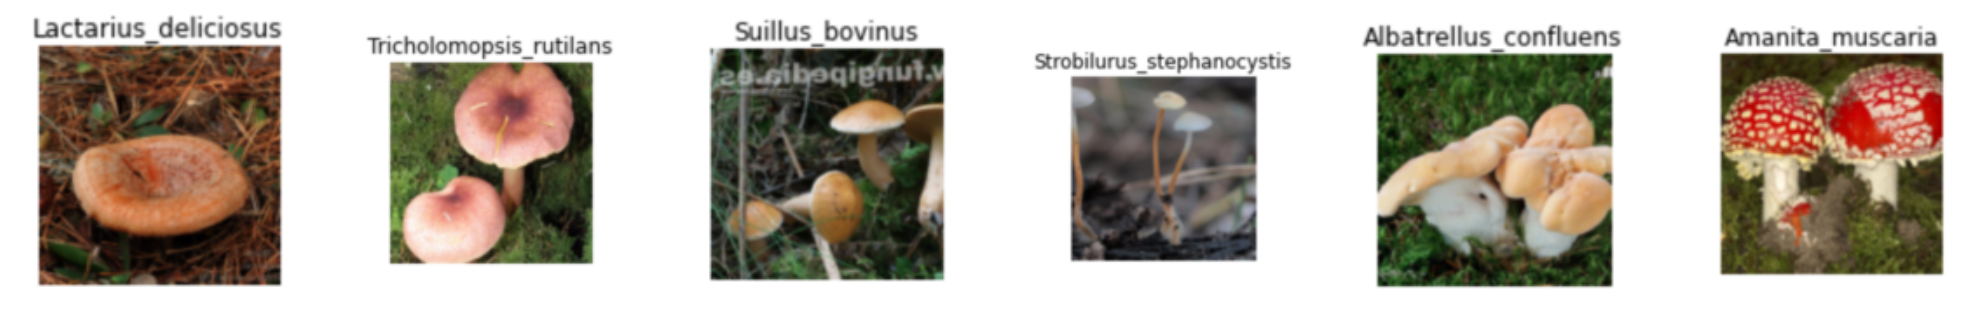

Unacceptable images:

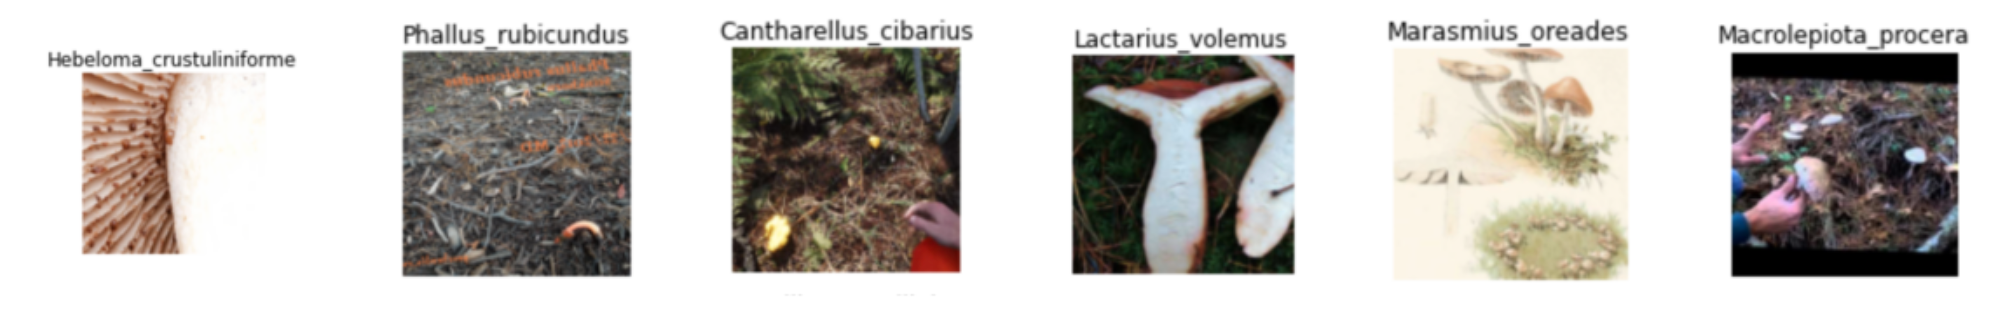

## Training the neural net 

In the first version of the project, I restricted myself to the techniques introduced to me in the first three lessons of the course ["practical deep learning for coders"](https://course.fast.ai/). For this version of the project I tried out some.  

For our neural net architecture, we will choose resnet50, a convolutional neural network designed to perform well on image classification tasks. Rather than initializing the parameters of the neural net randomly, we will use a pre-trained version of resnet50 that has been trained with over 1 million images from the [imagenet](http://www.image-net.org/) database, consisting of images from 1000 categories. This idea is known as transfer learning. Transfer learning will allow us to train a neural network that is good at recognizing images of mushrooms, with a relatively small amount of data. It works because the neural net starts out already able to recognize images, it only needs to be fine-tuned and specialized to recognize mushroom images.  

Another idea that can be useful when working limited datasets is to generate more data from the data that you already have by applying transformations, this is known as data augmentation. When choosing which transforms we will apply to our data there are two important considerations:

1. The transforms should change the images enough to them look different from the original images.
2. The transforms should not change the image so much that it no longer resembles an image of a mushroom. 

The fastai library has a method known as "get_transforms()", by default this method fetches the following transforms, which are each applied with a certain probability each time an image is shown to the neural network:

1. Flipping across the horizontal axis
2. Rotation between -10 degrees and 10 degrees
3. Zoom between 1x and 1.1x
4. Lighting and contrast change
5. A symmetric warp of magnitude between -0.2 and 0.2

I used the default set of transform for this initials version of the classifier. A good source for a more detailed explanation of these transforms with examples, is the fastai documentation for [get_transforms](https://docs.fast.ai/vision.transform.html#get_transforms).

This model was trained using the fastai implementation of the one cycle fitting policy developed by Leslie Smith. Kostas Mavropalias has laid out an excellent explanation of the one cycle fitting policy, found [here](https://iconof.com/1cycle-learning-rate-policy/).

We import all the necessary packages. We will be building our classifier using the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/), which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). 

In [1]:
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
path = Path('mushroom_classification_data_cleaned/')

In [3]:
df = pd.read_csv(path/'cleaned.csv', header='infer')

In [4]:
def get_data_learner(bs, size):
    tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2)
    np.random.seed(33)
    data = ImageDataBunch.from_df(path, df, valid_pct=0.2, ds_tfms=tfms, size=size, bs=bs).normalize(imagenet_stats)
    learn = cnn_learner(data, models.resnet50, metrics=error_rate)
    return data, learn

In [7]:
data, learn = get_data_learner(bs=64, size=224)

In [53]:
data.train_ds

LabelList (13384 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus
Path: mushroom_classification_data_cleaned

In [54]:
data.valid_ds

LabelList (3345 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Calocybe_gambosa,Kuehneromyces_mutabilis,Cortinarius_rubellus,Paxillus_atrotomentosus,Cantharellus_cibarius
Path: mushroom_classification_data_cleaned

In [55]:
x,y = data.train_ds[0]

Hortiboletus_rubellus


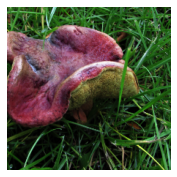

In [56]:
print(y)
x.show()

In [57]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_zoom=1.3, max_lighting=0.35)
print(len(tfms))

2


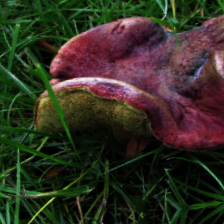

In [58]:
x.apply_tfms(tfms[0])

In [59]:
def plot_tfms(image, rows, cols, height, width, **kwargs):
    [x.apply_tfms(tfms[0], **kwargs).show(ax=ax) for i, ax in enumerate(plt.subplots(rows, cols, figsize=(width, height))[1].flatten())]      

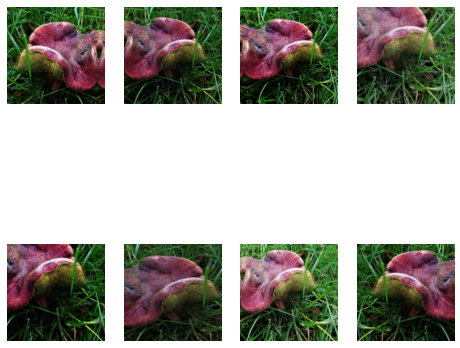

In [60]:
plot_tfms(x, 2, 4, 8, 8, size=224)

After reading in the cleaned data, cropping and resizing the images to size 224 by 224 pixels, choosing a set of transforms for data augmentation and randomly splitting the data into a training set (80%), and a validation set (20%). I looked at several random subsets of the data (example below) to make sure that images were cropped and resized properly. The Data were also normalized using the same stats as were used during the pretraining of resnet50. 

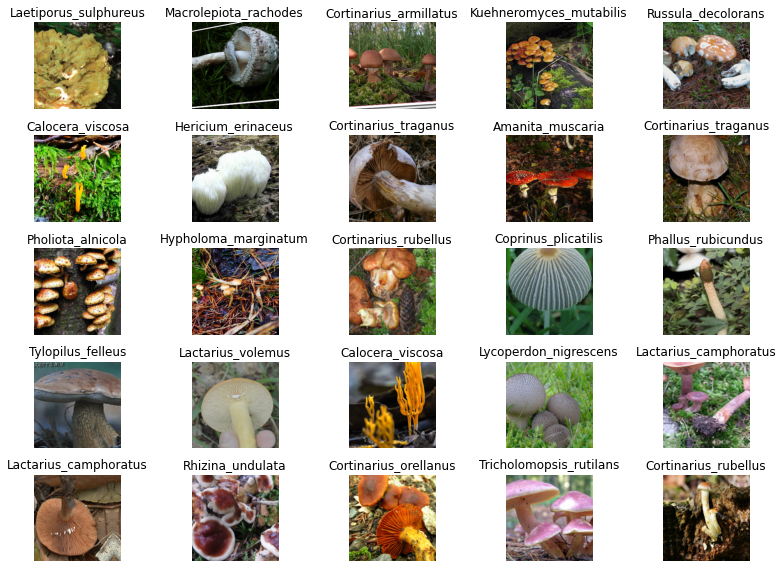

In [46]:
data.show_batch(rows=5, figsize=(11,8))

In [61]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [5]:
def find_plot_lr(learner):
    learner.lr_find()
    learner.recorder.plot()

I initiated a fastai convolutional neural network learner by putting the data together with the resnet50 pretrained model and choosing a metric (error rate) for model evaluation. I explored a range of learning rates and made a plot of learning rates against losses to help me choose an efficient learning rate. We are looking for the learning rate that corresponds to the steepest negative slope in the figure. That's the learning rate that is expected to lead to the quickest decrease in the loss function, i.e., the most efficient learning. From the plot, it looks like the steepest slope could lie anywhere between 0.001 and 0.01. After some experimentation, I settled on a learning rate of 0.01.

## Begin of progressive resize

In [6]:
data, learn = get_data_learner(bs=64, size=56)

In [7]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 28, 28]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 28, 28]         128        True      
______________________________________________________________________
ReLU                 [64, 28, 28]         0          False     
______________________________________________________________________
MaxPool2d            [64, 14, 14]         0          False     
______________________________________________________________________
Conv2d               [64, 14, 14]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
Conv2d               [64, 14, 14]         36,864     False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


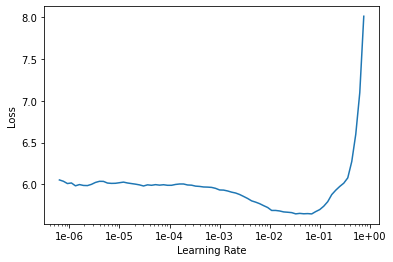

In [14]:
find_plot_lr(learn)

In [15]:
learn.fit_one_cycle(10, max_lr=1e-2)

In [16]:
learn.save('56-stage-1')

In [8]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


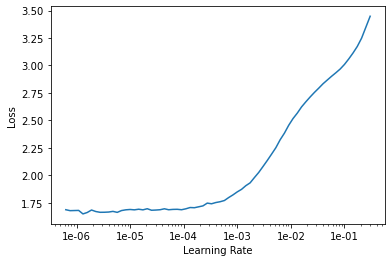

In [23]:
find_plot_lr(learn)

In [24]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

In [27]:
learn.save('56-stage-2')

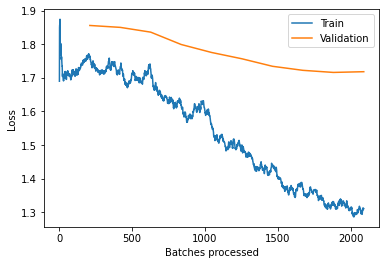

In [26]:
learn.recorder.plot_losses()

In [7]:
learn.load('56-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (13384 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus
Path: mushroom_classification_data_cleaned;

Valid: LabelList (3345 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
Calocybe_gambosa,Kuehneromyces_mutabilis,Cortinarius_rubellus,Paxillus_atrotomentosus,Cantharellus_cibarius
Path: mushroom_classification_data_cleaned;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

In [9]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

In [10]:
learn.save('56-stage-final')

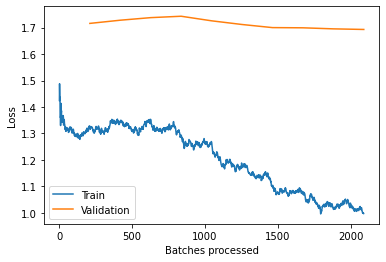

In [11]:
learn.recorder.plot_losses()

In [6]:
data, learn = get_data_learner(bs=64, size=112)

In [9]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 56, 56]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________________
MaxPool2d            [64, 28, 28]         0          False     
______________________________________________________________________
Conv2d               [64, 28, 28]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 28, 28]         128        True      
______________________________________________________________________
Conv2d               [64, 28, 28]         36,864     False     
___________________________________________________

In [7]:
learn.load('56-stage-final')

Learner(data=ImageDataBunch;

Train: LabelList (13384 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus
Path: mushroom_classification_data_cleaned;

Valid: LabelList (3345 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
Calocybe_gambosa,Kuehneromyces_mutabilis,Cortinarius_rubellus,Paxillus_atrotomentosus,Cantharellus_cibarius
Path: mushroom_classification_data_cleaned;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


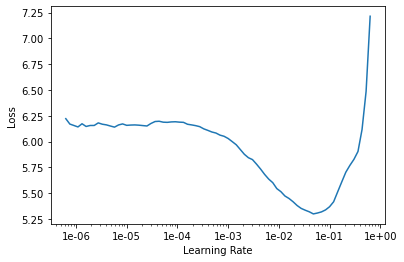

In [15]:
find_plot_lr(learn)

In [8]:
learn.fit_one_cycle(10, max_lr=1e-2)

In [9]:
learn.save('112-stage-1')

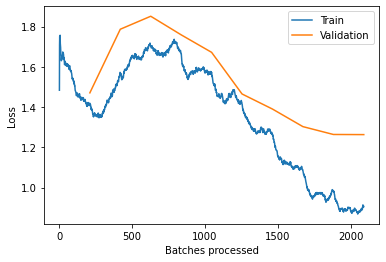

In [10]:
learn.recorder.plot_losses()

In [12]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


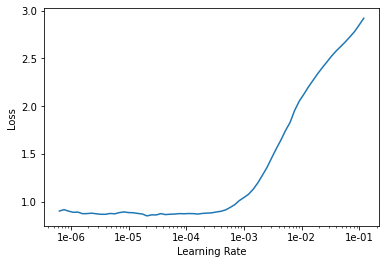

In [13]:
find_plot_lr(learn)

In [14]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

In [15]:
learn.save('112-stage-2')

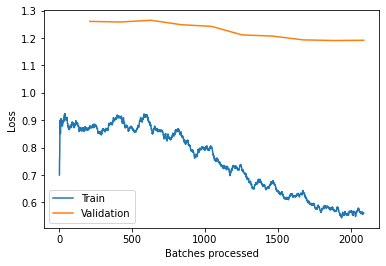

In [16]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


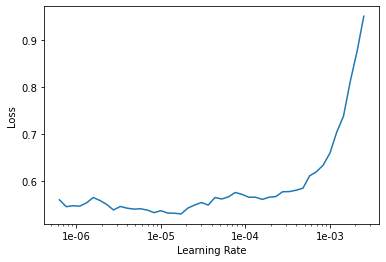

In [17]:
find_plot_lr(learn)

In [18]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

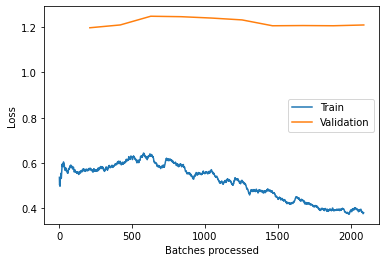

In [19]:
learn.recorder.plot_losses()

In [20]:
learn.save('112-stage-final')

In [21]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 56, 56]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________________
MaxPool2d            [64, 28, 28]         0          False     
______________________________________________________________________
Conv2d               [64, 28, 28]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 28, 28]         128        True      
______________________________________________________________________
Conv2d               [64, 28, 28]         36,864     True      
___________________________________________________

In [7]:
data, learn = get_data_learner(bs=64, size=224)

In [8]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [29]:
learn.load('112-stage-final')

Learner(data=ImageDataBunch;

Train: LabelList (13384 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus
Path: mushroom_classification_data_cleaned;

Valid: LabelList (3345 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Calocybe_gambosa,Kuehneromyces_mutabilis,Cortinarius_rubellus,Paxillus_atrotomentosus,Cantharellus_cibarius
Path: mushroom_classification_data_cleaned;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


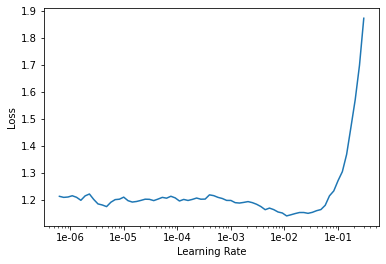

In [25]:
find_plot_lr(learn)

In [31]:
learn.fit_one_cycle(10, max_lr=1e-2)

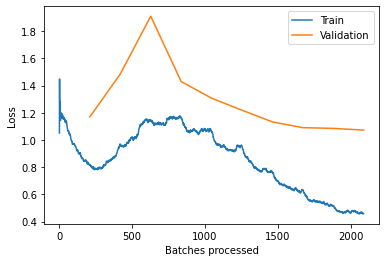

In [32]:
learn.recorder.plot_losses()

In [36]:
learn.save('224-stage-1')

In [22]:
learn.load('224-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (13384 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus,Hortiboletus_rubellus
Path: mushroom_classification_data_cleaned;

Valid: LabelList (3345 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Calocybe_gambosa,Kuehneromyces_mutabilis,Cortinarius_rubellus,Paxillus_atrotomentosus,Cantharellus_cibarius
Path: mushroom_classification_data_cleaned;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4)

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


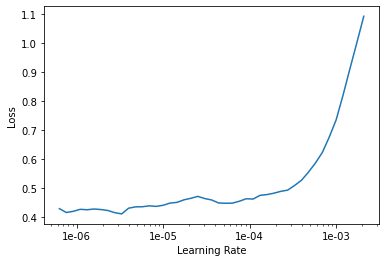

In [24]:
find_plot_lr(learn)

In [26]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

In [27]:
learn.save('224-stage-2')

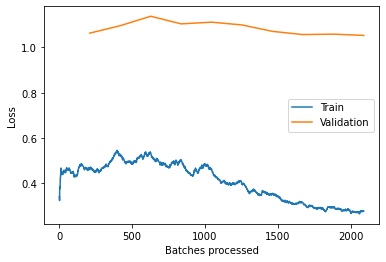

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
___________________________________________________

## End of progressive resize

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


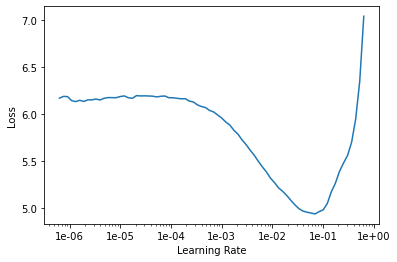

In [64]:
find_plot_lr(learn)

In [14]:
learn.fit_one_cycle(10, max_lr=1e-2)

In [15]:
learn.save('stage-1-1e-2')

In [6]:
learn.fit_one_cycle(10, max_lr=1e-3)

mention: Adam optimizer and regularization

In [7]:
learn.save('stage-1')

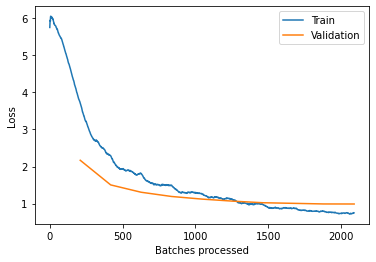

In [8]:
learn.recorder.plot_losses()

In [40]:
xb, _ = data.one_batch()
xb.shape

torch.Size([32, 3, 224, 224])

In [87]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


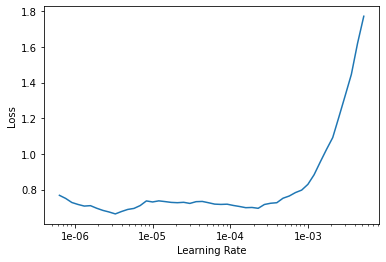

In [89]:
find_plot_lr(learn)

In [90]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 224, 224]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
MaxPool2d            [64, 112, 112]       0          False     
______________________________________________________________________
Conv2d               [64, 112, 112]       4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
Conv2d               [64, 112, 112]       36,864     True      
___________________________________________________

In [91]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,3e-4))

In [92]:
learn.save('stage-2')

After training the network for 10 epochs, I plotted the training and validation losses (cross-entropy loss was chosen as the loss function). Training loss dips permanently under validation loss after about 1500 batches processed, indicating that the model is not being under fitted to the data. Training loss and validation loss both appear to be flattening out by the end of the training cycle, so at this point, we already have a model that is neither overfitted nor under fitted to the data. Up until now, we have only been training the output layer of the network, parameters (weights and biases) from earlier layers have not been allowed to change. The next step is to train the parameters from earlier layers of the network and see if that helps to improve the model. To do that I first unfreeze the model and use the learning rate finder to guide me in choosing a learning rate for the next stage of training. When training the unfrozen model, rather than just specifying a single maximum learning rate, we specify a lower bound and an upper bound for the maximum learning rate. In the example below the lower bound is 1e-5 and the upper bound is 5e-4. The first layer will be trained (using one cycle fitting) with a max learning rate of 1e-5. The learning rate for subsequent layers is increased linearly until finally the last layer is trained using a max learning rate of 5e-4. 

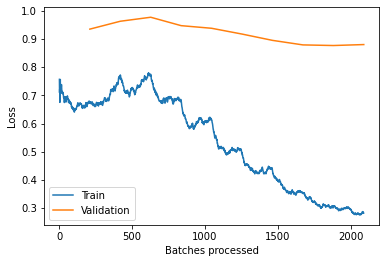

In [35]:
learn.recorder.plot_losses()

The training loss and the validation loss appeared to be leveling out after 10 more epochs of training. I decided to try another couple of stages of fine-tuning to see if I could improve the accuracy a bit more. 

After the two more stages of fine-tuning, the error rate on the validation set didn't decrease much, and the training loss and the validation loss both leveled off. I was satisfied that the model couldn't be improved any futher and that any more training would gradually lead to overfitting.

## Modeling results

In [24]:
# The classificationInterpretation object contains all the information needed to interperate the model.
# Basically exactly the things that I will looking at in the next few cells
interp = ClassificationInterpretation.from_learner(learn)

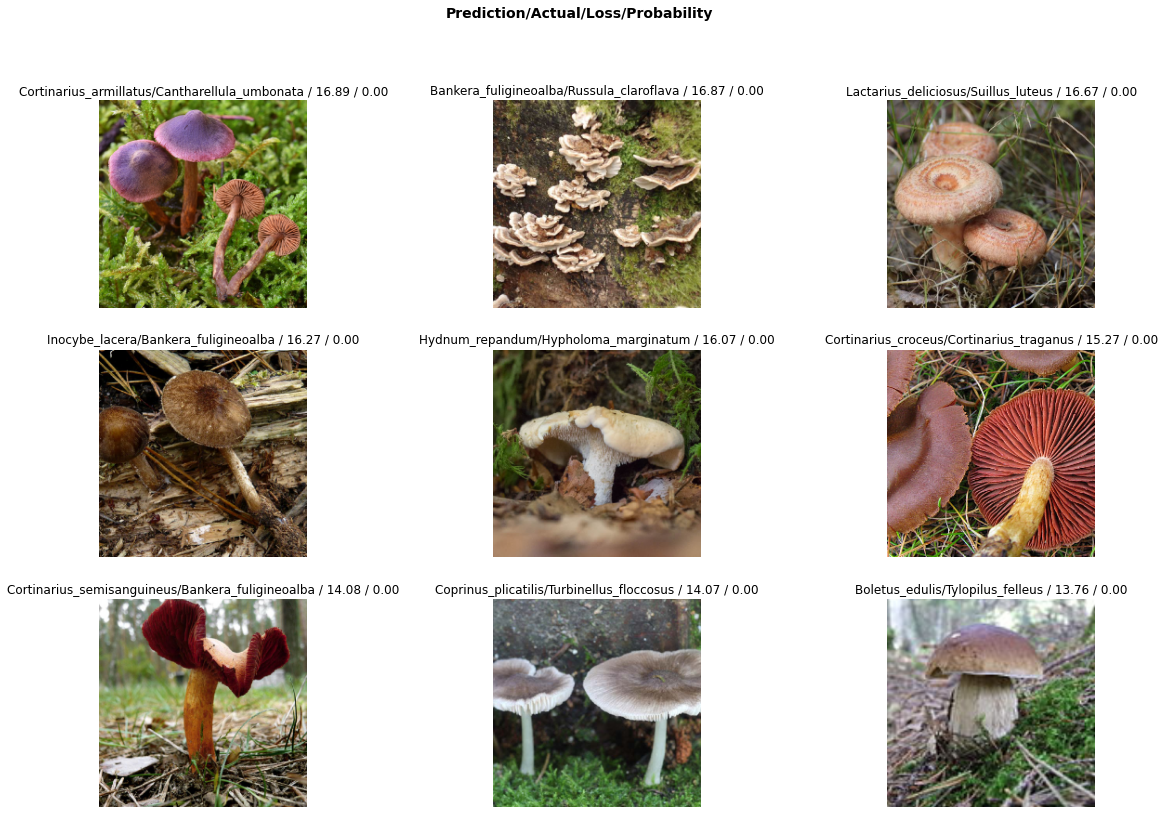

In [25]:
# explain top losses and mention how it was used in the second data cleaning step.
interp.plot_top_losses(9, figsize=(20,13))

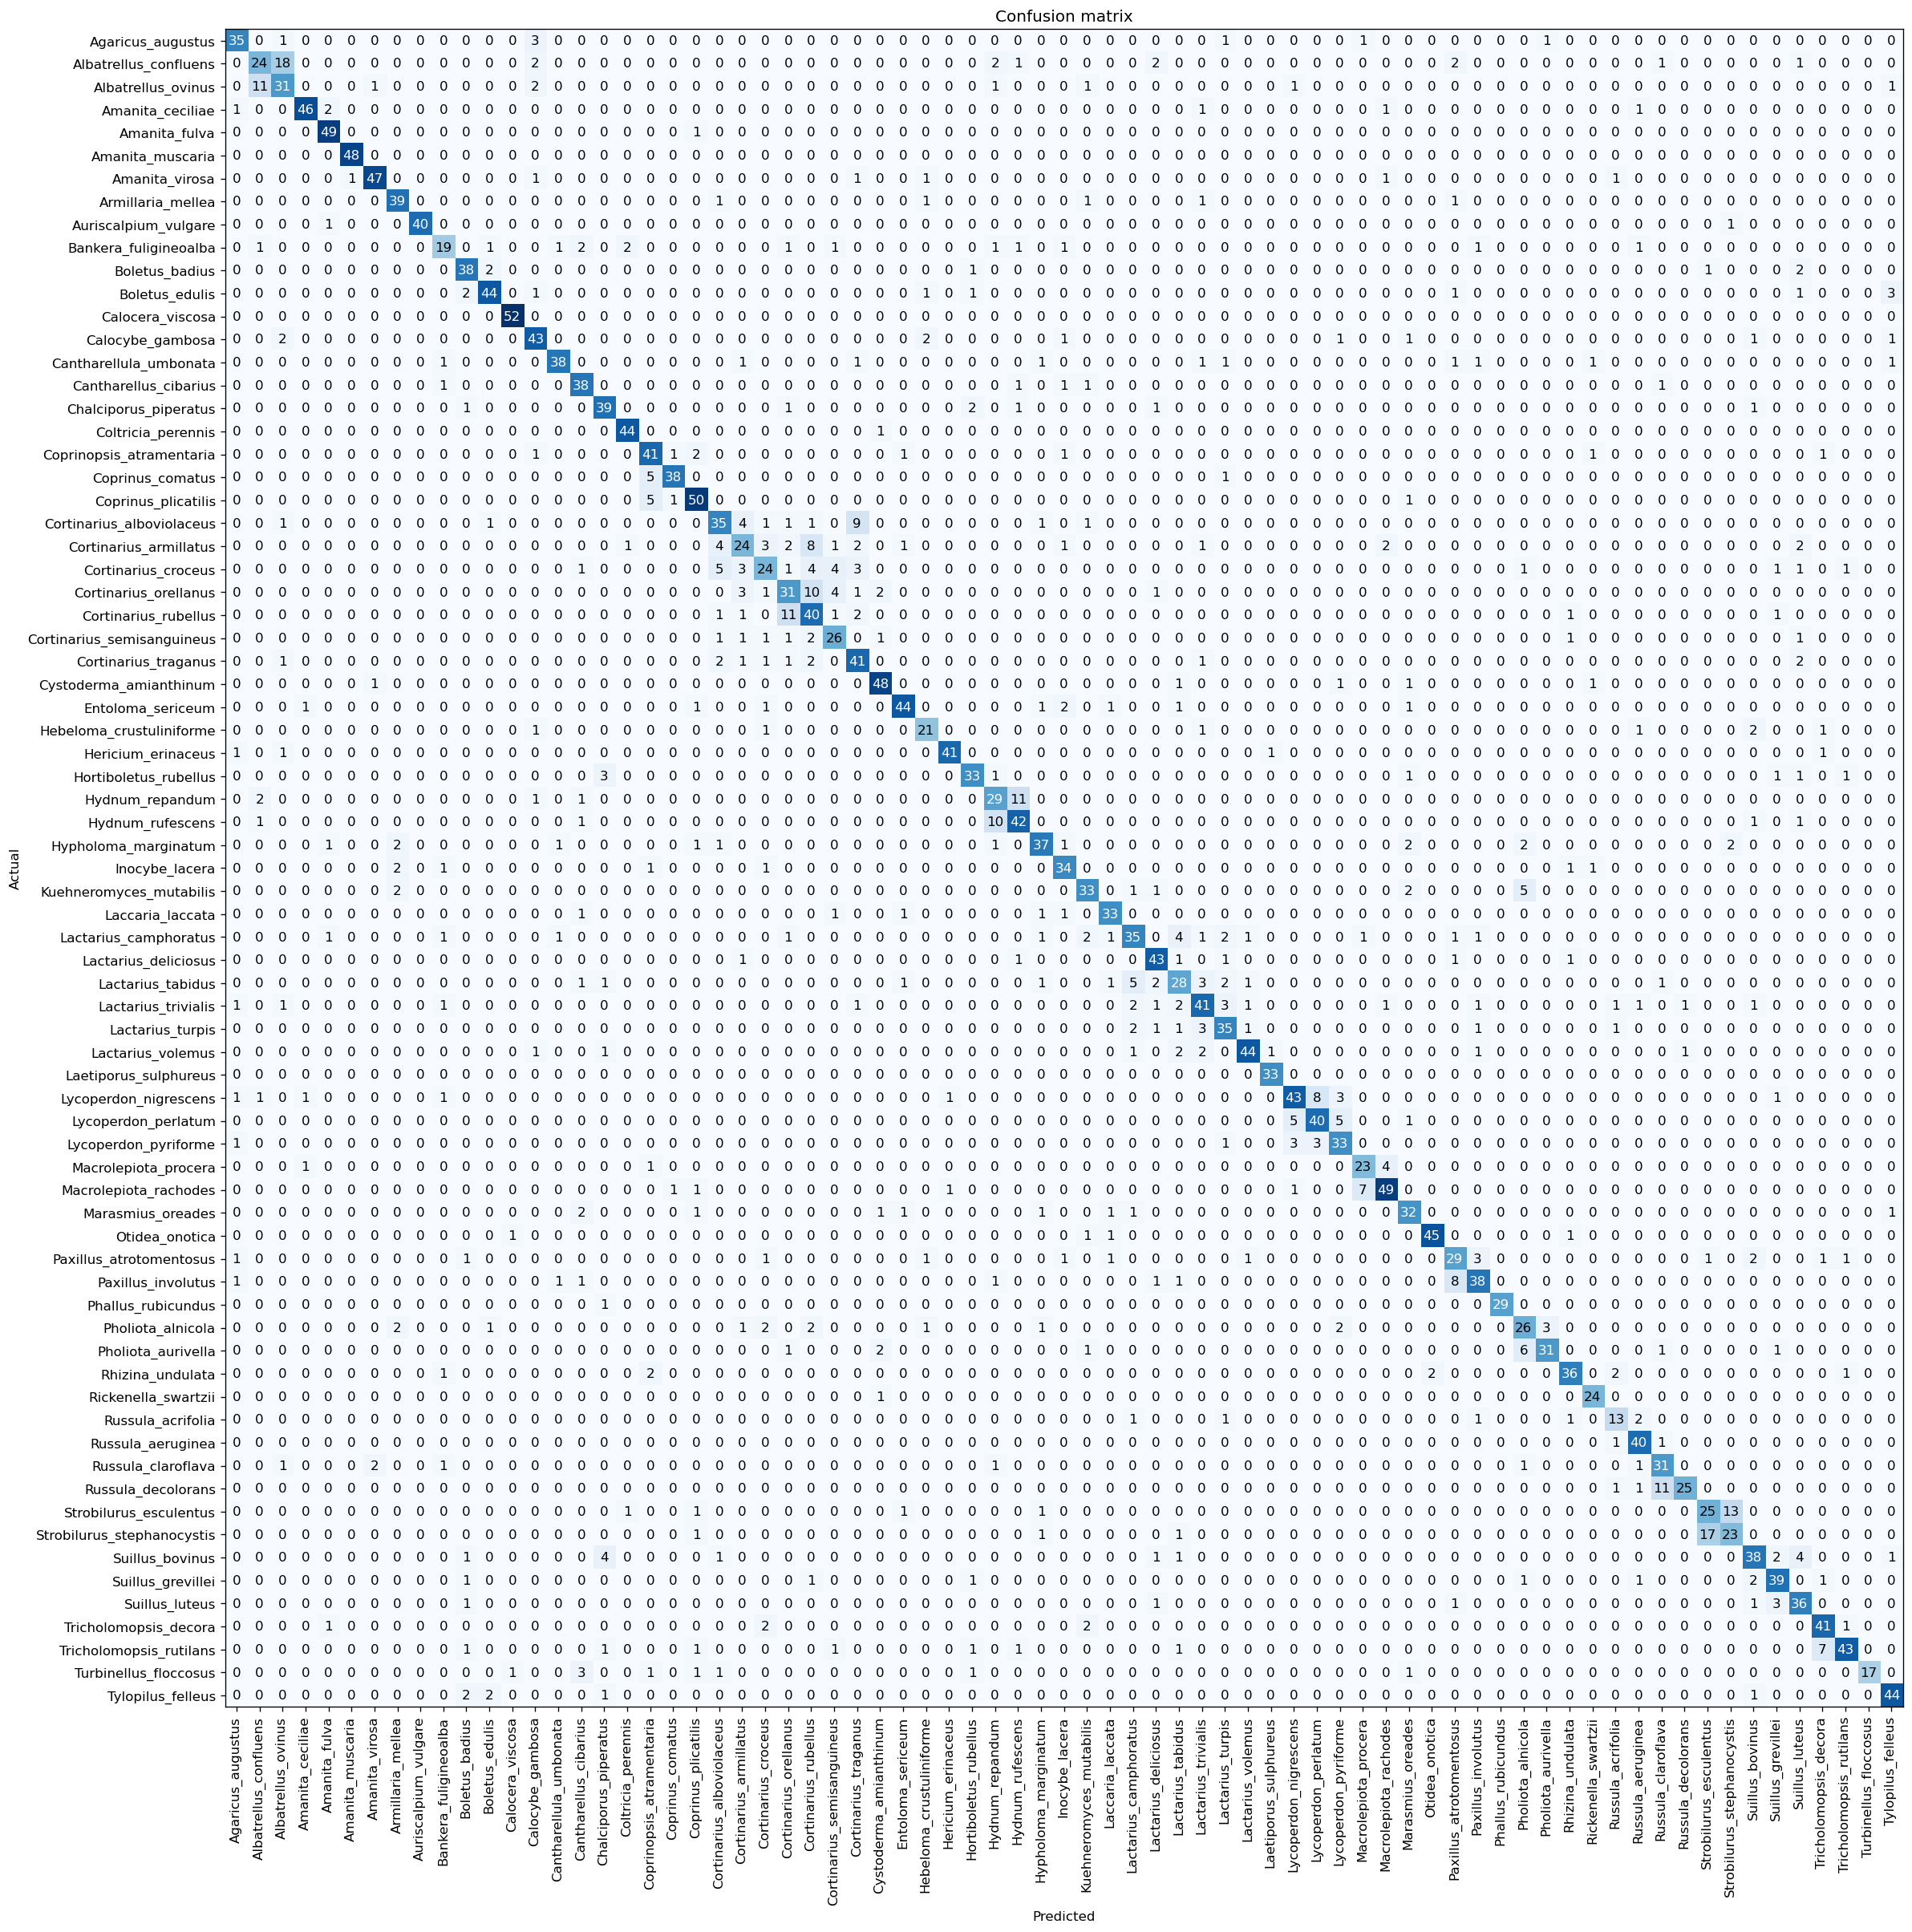

In [26]:
# explain confusion matrix and interperate.
interp.plot_confusion_matrix(figsize=(20,20), dpi=120)

In [27]:
# Same info as in confusion matrix but easier to see the worst cases.
# interperate.
interp.most_confused(min_val=5)

[('Albatrellus_confluens', 'Albatrellus_ovinus', 18),
 ('Strobilurus_stephanocystis', 'Strobilurus_esculentus', 17),
 ('Strobilurus_esculentus', 'Strobilurus_stephanocystis', 13),
 ('Albatrellus_ovinus', 'Albatrellus_confluens', 11),
 ('Cortinarius_rubellus', 'Cortinarius_orellanus', 11),
 ('Hydnum_repandum', 'Hydnum_rufescens', 11),
 ('Russula_decolorans', 'Russula_claroflava', 11),
 ('Cortinarius_orellanus', 'Cortinarius_rubellus', 10),
 ('Hydnum_rufescens', 'Hydnum_repandum', 10),
 ('Cortinarius_alboviolaceus', 'Cortinarius_traganus', 9),
 ('Cortinarius_armillatus', 'Cortinarius_rubellus', 8),
 ('Lycoperdon_nigrescens', 'Lycoperdon_perlatum', 8),
 ('Paxillus_involutus', 'Paxillus_atrotomentosus', 8),
 ('Macrolepiota_rachodes', 'Macrolepiota_procera', 7),
 ('Tricholomopsis_rutilans', 'Tricholomopsis_decora', 7),
 ('Pholiota_aurivella', 'Pholiota_alnicola', 6),
 ('Coprinus_comatus', 'Coprinopsis_atramentaria', 5),
 ('Coprinus_plicatilis', 'Coprinopsis_atramentaria', 5),
 ('Cortinarius

## Model evaluation

>Random baseline: if your model just predicts everything at random, what's the
expected performance?
• Human baseline: how well would humans perform on this task?
• Simple heuristic: for example, for the task of recommending the app to use next on
your phone, the simplest model would be to recommend your most frequently used
app. If this simple heuristic can predict the next app accurately 70% of the time, any
model you build has to outperform it significantly to justify the added complexity.

## Summary

In version1 of the project:

I gathered and cleaned mushroom images for 58 of the most common species found in the BC area, along with 18 species that are known to look similar to those 58 species. After cleaning, there remained images for 73 classes of mushrooms. I applied transformations to augment the data. Finally, I trained a classifier by finetuning a pretrained resnet50 model. The classifier achieved an error rate of 22% (88% accuracy). In contrast, the same model finetuned using the uncleaned data achieved an error rate of ~32%.

In this version:

- for size 224 the best bs was the default size=64
- with bs= 64 the best image size was size=224
- overall the best image size was size= 448, but had to us bs=32 in this case to fit everything into memory and training time increased by a factor of 2.5

## Future work

Mushroom species classification is both an interesting problem because of its utility and because of the challenge that it presents. I intend to continue to improve the accuracy and generalizability of this model as I learn more about deep learning and other machine learning models and tools. The final step in this project will be to field test the model and put it into production making available to the BC mushroom foraging community. There are several possible avenues that I already have in mind that may improve the model. 

### ~~Data augmentation~ (completed in this version)

~~It may be possible to increase the generalizability and accuracy of the model by including more transforms (such as random cropping and resizing, random resizing and cropping) in the data augmentation step.~

~~I also noticed that there are some images of upside-down mushrooms in my data set, leading me to believe that it is a good idea to include a vertical flip transform.~

~~These steps should help to make the model able to handle images that contain a wide range of mushroom orientations or that capture only part of a mushroom, allowing me to simplify the instructions that a user will need to understand and follow to get a reliable prediction from the model.~

### Progressive resizing

The idea behind progressive resizing is to increase the amount of data that your model sees in training by train a model on several resized versions of your data set. Typically you start with images of a smaller size than the final size that you intend to use to train the final model and work your way up to this maximum size. For instance, a resizing workflow for our application might look like this:

1. Finetune resnet50 using our images resized to 56x56 pixels and save this model.
2. Finetune the model obtained in step 1 using our images resized to 122x112 pixels and save this model.
3. Finetune the model in step 2 using our images resized to 224x224 pixels.

### Including more features  

"""A mushroom guide is a must for anyone interested in foraging for mushrooms. It's helpful if the guide includes pictures of poisonous mushrooms, but because of the sheer number of possibilities, it's even more helpful if the guide can zero in on a species as you enter information about the specimen you found. One such mushroom guide, posted by researchers from the University of Aarhus and University of Copenhagen, Denmark, is available online. It's called MycoKey, and it isn't the only such guide.

A number of factors enter into a positive identification. They include not just appearance, but also location, season and growing conditions. Even if you can't make a positive identification, some general characteristics can alert you to the likelihood of a dangerous species."""

Many mushroom species (particularly those in the same family) are  similar in apearance. Musroom guides such as the one created by researchers from the University of Aarhus and University of Copenhagen([MycoKey](http://www.mycokey.com/)), typically incorparate a number of factors beyond appearance when trying to make a positive identification. These factors include location, season, and growing conditions.

### Data collection

Another way that the accuracy and generalizability of the model could be improved is to train it using more data. This means finding more images for each of the 73 categories of mushrooms that make up the scope of the classifier and or expanding the scope of the classifier by added more mushroom categories. It will be necessary to expand the number of categories somewhat to cover more of the possible mushrooms that BC foragers could run into out in the woods. For instance, the Amanita phalloides (AKA 'death cap') mushroom often closely resembles the Lycoperdon perlatum (AKA 'Common puffball') mushroom, which is inside the scope of the classifier. Amanita phalloides isn't included in this first version of the classifier, which could lead to unfortunate consequences if the model were deployed as-is. One possible source to draw on comes from Denmark. The University of Copenhagen issued a fungi classification challenge in 2018. As part of the challenge, they released a [dataset](https://snm.ku.dk/english/news/all_news/2018/2018.5/the-fungi-classification-challenge/) contained 1,394 wild mushrooms species, with 85,578 training images and 4,182 validation images. Location, season, and growing condition data (among other things) will also need to be collected to fulfill the goals outlined in the previous section. 

### Model evaluation

I used error rate (1 - accuracy) as the metric to evaluate this model. This was a reasonable choice because we have a multiclass classification problem with balanced classes. In future interations of the project it will be important to determine if the model is classifying any poisonous or deadly mushrooms as edible. Percision with respect to the edible class, will provide a ideal metric for this sort of evaluation. 
